In [203]:
from classifier import classifier
import numpy as np


class logistic_regression(classifier):

    def __init__(self):
        self.k1 = 1.3
        self.b = None
        self.alphas = None
        self.C = 0.6
        self.toler = 0.001
        self.maxIter = 40
#         self.w = None
#         self.svInd = None
#         self.sVs = None
#         self.labelSV = None
        

    def fit(self, X, Y):
        self.b, self.alphas = smoPK(X, Y, self.C, self.toler, self.maxIter)
        self.w = calcWs(self.alphas,X,Y)
#         datMat=mat(X)
#         labelMat = mat(Y).transpose()
#         self.svInd=nonzero(self.alphas.A>0)[0]
#         self.sVs=datMat[self.svInd]  #get matrix of only support vectors
#         self.labelSV = labelMat[self.svInd]
        return 
 
    def predict(self, X):
        predict = np.sign(np.dot(np.array(X),self.w)+self.b)
        return predict.astype(int)
        # sign( x.w+b )
#         hypotheses = []
#         m,n = shape(mat(X))
#         for i in range(m):
#             predict = np.sign(multiply(self.labelSV,self.alphas[self.svInd])+self.b)
#             hypotheses.append(predict.item(0,0))
#         return hypotheses

    def plot_graph(self,X):
        colors = {1:'r',-1:'b'}
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        max_feature_value=float('-inf')
        min_feature_value=float('+inf')
        for yi in range(len(X)):
            if np.amax(X[yi])>max_feature_value:
                max_feature_value=np.amax(X[yi])
                
            if np.amin(X[yi])<min_feature_value:
                min_feature_value=np.amin(X[yi])
        
        plt.scatter(dataFrame['x1'],dataFrame['x2'],marker='o',c=dataFrame['c'])
        def hyperplane_value(x,w,b,v):
            return (-w[0]*x-b+v) / w[1]
        datarange = (min_feature_value*0.9,max_feature_value*1.)
        hyp_x_min = datarange[0]
        print(hyp_x_min)
        hyp_x_max = datarange[1]
        print(hyp_x_max)
        db1 = hyperplane_value(hyp_x_min, self.w, self.b, 0)
        print(type(db1))
        db2 = hyperplane_value(hyp_x_max, self.w, self.b, 0)
        print(db2.item(0,0))
        ax.plot([hyp_x_min,hyp_x_max],[db1.item(0,0),db2.item(0,0)], 'y--')
       

In [117]:
from numpy import *
from pandas import *
from time import sleep

def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split(',')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

def loadDataFrame(fileName):
    df = read_csv(fileName)
    df.columns = ["x1", "x2", "c"]
    return df

def selectJrand(i,m):
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

In [118]:
class optStructK:
    def __init__(self,dataMatIn, classLabels, C, toler):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2))) #first column is valid flag
        
def calcEkK(oS, k):
    fXk = float(multiply(oS.alphas,oS.labelMat).T*(oS.X*oS.X[k,:].T)) + oS.b
    Ek = fXk - float(oS.labelMat[k])
    return Ek
        
def selectJK(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: continue #don't calc for i, waste of time
            Ek = calcEkK(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:   #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEkK(oS, j)
    return j, Ej

def updateEkK(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEkK(oS, k)
    oS.eCache[k] = [1,Ek]
        
def innerLK(i, oS):
    Ei = calcEkK(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJK(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: print("L==H"); return 0
        eta = 2.0 * oS.X[i,:]*oS.X[j,:].T - oS.X[i,:]*oS.X[i,:].T - oS.X[j,:]*oS.X[j,:].T
        if eta >= 0: print("eta>=0"); return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEkK(oS, j) #added this for the Ecache
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): print("j not moving enough"); return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEkK(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

def smoPK(dataMatIn, classLabels, C, toler, maxIter):    #full Platt SMO
    oS = optStructK(mat(dataMatIn),mat(classLabels).transpose(),C,toler)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerLK(i,oS)
                print("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerLK(i,oS)
                print("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): entireSet = True  
        print("iteration number: %d" % iter)
    return oS.b,oS.alphas

def calcWs(alphas,dataArr,classLabels):
    X = mat(dataArr)
    labelMat = mat(classLabels).transpose()
    m,n = shape(X)
    w = zeros((n,1))
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

In [11]:
dataArr, labelArr = loadDataSet('linearly_separable.csv')

In [12]:
dataFrame = loadDataFrame('linearly_separable.csv')

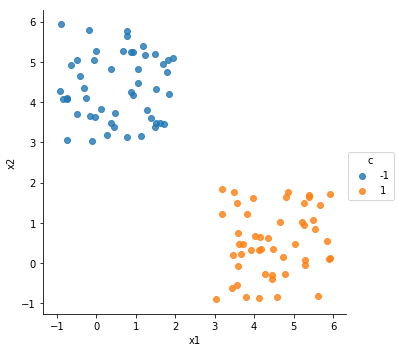

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
sns.lmplot(x="x1", y="x2",hue="c",data=dataFrame,fit_reg=None, y_jitter=.02, logistic=True);

In [204]:
clf = logistic_regression()
clf.fit(dataArr,labelArr)
hypotheses = clf.predict(dataArr)

L==H
fullSet, iter: 0 i:0, pairs changed 0
L==H
fullSet, iter: 0 i:1, pairs changed 0
fullSet, iter: 0 i:2, pairs changed 1
fullSet, iter: 0 i:3, pairs changed 1
fullSet, iter: 0 i:4, pairs changed 2
L==H
fullSet, iter: 0 i:5, pairs changed 2
fullSet, iter: 0 i:6, pairs changed 2
L==H
fullSet, iter: 0 i:7, pairs changed 2
fullSet, iter: 0 i:8, pairs changed 3
fullSet, iter: 0 i:9, pairs changed 3
fullSet, iter: 0 i:10, pairs changed 3
fullSet, iter: 0 i:11, pairs changed 4
j not moving enough
fullSet, iter: 0 i:12, pairs changed 4
j not moving enough
fullSet, iter: 0 i:13, pairs changed 4
fullSet, iter: 0 i:14, pairs changed 4
fullSet, iter: 0 i:15, pairs changed 4
j not moving enough
fullSet, iter: 0 i:16, pairs changed 4
fullSet, iter: 0 i:17, pairs changed 4
fullSet, iter: 0 i:18, pairs changed 5
fullSet, iter: 0 i:19, pairs changed 5
fullSet, iter: 0 i:20, pairs changed 5
fullSet, iter: 0 i:21, pairs changed 5
fullSet, iter: 0 i:22, pairs changed 5
fullSet, iter: 0 i:23, pairs chan

In [156]:
predicted = np.array(hypotheses).ravel().tolist()

[1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1]
[1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


-0.834777182852
5.93361973806
<class 'numpy.matrixlib.defmatrix.matrix'>
6.790766093161504


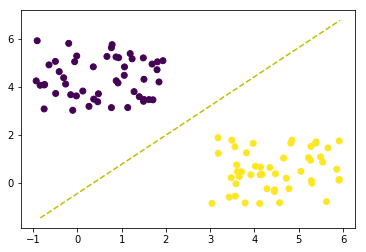

In [205]:
clf.plot_graph(dataArr)